In [4]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
import nltk

In [524]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
import pandas as pd
import regex as re

parse_data = []
msg_buffer = []
# Pattern1 doesn't include unsaved contacts and the media ommitted messages
# It includes all messages starting with timestamp
pattern1 = re.compile(
    r"((^\[\d+.\d+.\d+),\s((\d+.)+[amp]+)\]).([a-zA-Z'\d\s\+]+):(.*)")
# Pattern2 only includes messages starting with letters not with emoji! sad! :(
pattern2 = re.compile(
    r"^([a-zA-Z0-9.*\s%&\$’\_()+^@#\-:]+)")


def clean_message(raw_message):
    '''
    Cleans the raw messages and removes any non-ascii characters like u200 etc
    '''
    message = raw_message.encode('ascii', 'ignore').decode()
    return message


def tokenise(messages, pattern1, pattern2):
    # Initialising variables because we are declaring them late(due to msg buffer)
    date, time_stamp, member = None, None, None
    for raw_message in messages:
        message = clean_message(raw_message)
        result = re.match(pattern1, message)
        if result:
            if len(msg_buffer) > 0:
                parse_data.append(
                    [date, time_stamp, member, ' '.join(msg_buffer)])  # Only appending once messages are reconciled with buffer
            msg_buffer.clear()  # CLearning the buffer once parsed
            # Tokens are populated only once the buffer is added to ensure previous token are used to populate the table
            member = result.group(5)
            date = result.group(2).split('[')[1]
            time_stamp = result.group(3)
            txt = result.group(6)  # used only for appending to buffer
            # declaring other tokens but only creating buffer for texts
            msg_buffer.append(txt)
        else:
            full_message(pattern2, message)


def full_message(pattern2, message):
    complete_msg = re.match(pattern2, message)
    if complete_msg:
        # adds to the msg buffer where ever messages start without author and date
        msg_buffer.append(complete_msg.group(1))
#     else:
#         print(message)


with open('whatsapp_chat_analysis/_chat.txt', mode='r') as chat:
    # print(chat.readline())
    messages = chat.readlines()
    # print(messages)
    tokenise(messages, pattern1, pattern2)

df = pd.DataFrame(parse_data, columns=['date', 'time_stamp', 'member', 'message'])
# print(df.head())
# print(df['message'].head())
df.to_csv('chat_clean.txt', sep='\t')


In [15]:
# Total messages
df.shape

(2971, 4)

In [16]:
df.columns

Index(['date', 'time_stamp', 'member', 'message'], dtype='object')

In [17]:
# # Member and value counts for messages
# df['member'].value_counts()

In [11]:
df_messages = pd.DataFrame(df['member'].value_counts())
df_messages = df_messages.reset_index()
df_messages.columns = ['names', 'messages']

In [18]:
# Shortening of names
names = [i.split(' ')[0][0:3]+' '+i.split(' ')[1][0:2] if ' ' in i else i[0:5] for i in df_messages['names']]
df_messages['names'] = names

In [19]:
df_messages

,names,messages
0,Gau Ku,523
1,Vij RB,480
2,Gov Rb,280
3,Man Ge,274
4,Cra La,269
5,Sirsh,125
6,Dec Ch,122
7,Jamsh,101
8,Aar RB,93
9,Sha Tc,67


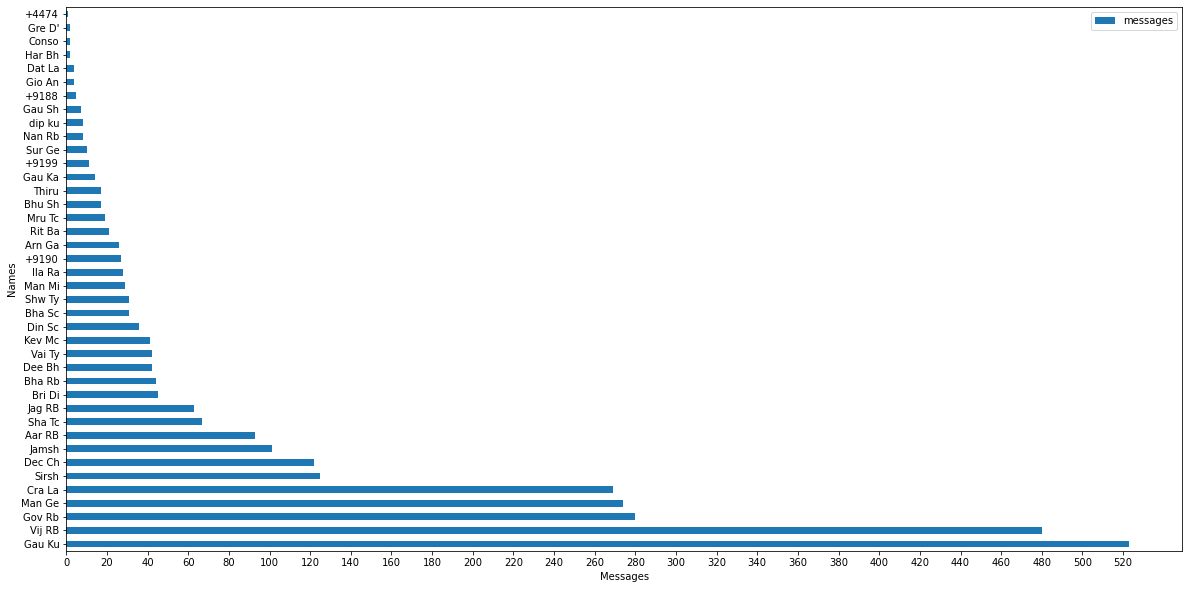

In [20]:
# Visualisation of who is most chatty
ax = df_messages.plot.barh(x='names', y='messages', figsize=(20, 10)) #by default df.plot uses ax as the plt figure obj
plt.xlabel('Messages')
plt.ylabel('Names')
# plt.yticks(df_messages.index, df_messages['names'])
plt.xticks(range(0, 540, 20))
plt.show()

In [21]:
def name_anon(name):
    if ' ' in name:
        return name.split(' ')[0][0:3]+' '+name.split(' ')[1][0:2]
    else: 
        return name[0:5]

In [22]:
# Using short names
df['ShortNames'] = df['member'].apply(lambda x: name_anon(x))

In [23]:
# Messages per member
df[['ShortNames', 'message']].groupby(['ShortNames']).count()
# df['member'].value_counts() -> Same result

,message
ShortNames,
+4474,1
+9188,5
+9190,27
+9199,11
Aar RB,93
Arn Ga,26
Bha Rb,44
Bha Sc,31
Bhu Sh,17


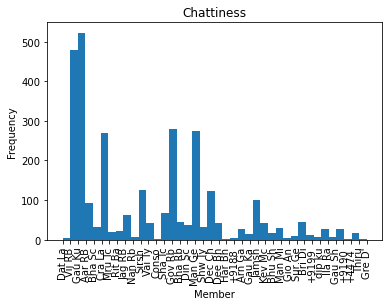

In [24]:
# Plotting chattiness of members using histogram
plt.hist(df['ShortNames'], bins=40)
# plt.xticks(fontsize=14)
# plt.figure().set_figwidth(100)
plt.xlabel('Member')
plt.ylabel('Frequency')
plt.title('Chattiness')
plt.xticks(rotation=90)
plt.show()

In [25]:
# Date column to date type
df['date'] = pd.to_datetime(df['date'])

In [26]:
# pd.to_datetime(df['time_stamp']).dt.strftime('%H:%M:%S')

In [27]:
df['date'].head()

0   2019-12-25
1   2019-12-25
2   2019-12-25
3   2019-12-25
4   2019-12-25
Name: date, dtype: datetime64[ns]

In [28]:
# Fixing am pm in timestamp
def am_pm(tstamp):
      suffix = tstamp.split(' ')[1]
      h,m,s = tstamp.split(' ')[0].split(':')[0], tstamp.split(' ')[0].split(':')[1], tstamp.split(' ')[0].split(':')[2]
      if suffix == 'pm':
            if int(h) == 12:
                return f'{h}:{m}:{s}' 
            return f'{str(int(h)+12)}:{m}:{s}'
      elif suffix == 'am' and int(h) == 12:
        return f'00:{m}:{s}'
      return tstamp.split(' ')[0]

In [29]:
# reducing time_Stamp to 24hr format
df['time_stamp'] = df['time_stamp'].apply(lambda x: am_pm(x))

In [30]:
# converting to date time format
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%H:%M:%S').dt.time

In [31]:
# start_time = pd.to_datetime('12:00:00').time()
# end_time = pd.to_datetime('17:00:00').time()
# df[(df['time_stamp'] > start_time) & (df['time_stamp'] < end_time)]

In [32]:
# capture media messages
media_omiited = df[df['message']==' image omitted']


In [33]:
# Who shared the most media
media_omiited.groupby('ShortNames').count()

,date,time_stamp,member,message
ShortNames,,,,
Bha Sc,3,3,3,3
Cra La,3,3,3,3
Dec Ch,3,3,3,3
Gau Ku,12,12,12,12
Gio An,1,1,1,1
Gov Rb,3,3,3,3
Ila Ra,1,1,1,1
Jag RB,1,1,1,1
Jamsh,1,1,1,1


In [34]:
# Define who took an off sick

def is_sick(message):
    unwell = ['off sick', 'off today', 'not well', 'unwell', 'taking off', 'taking leave', 'not feeling', 'leave today']
    for reason in unwell:
        if reason in message:
            return reason

        

In [35]:
# Create another column for sickness
df['sickness'] = df['message'].apply(lambda x: is_sick(x))

In [36]:
# Who was sick the most?
df[df['sickness'].notna()].groupby('ShortNames').count()

,date,time_stamp,member,message,sickness
ShortNames,,,,,
Aar RB,9,9,9,9,9
Arn Ga,2,2,2,2,2
Bha Sc,3,3,3,3,3
Bri Di,1,1,1,1,1
Cra La,23,23,23,23,23
Dec Ch,6,6,6,6,6
Dee Bh,5,5,5,5,5
Din Sc,1,1,1,1,1
Gau Ka,1,1,1,1,1


In [37]:
df_sickness = df[df['sickness'].notna()].groupby('sickness').agg({'sickness': 'count'})

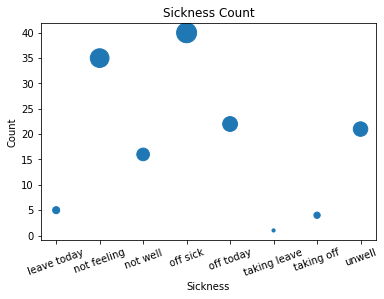

In [38]:
# Create scatter plot
plt.scatter(df_sickness.index, df_sickness['sickness'], s=df_sickness['sickness']*10)
plt.xlabel('Sickness')
plt.ylabel('Count')
plt.title('Sickness Count')
plt.xticks(rotation=20)
plt.show()

In [39]:
# Number of words used by each member per message
df['words'] = df['message'].apply(lambda x: len(x.split(' ')))

In [40]:
df_words = df[['ShortNames', 'words']].groupby('ShortNames').sum()

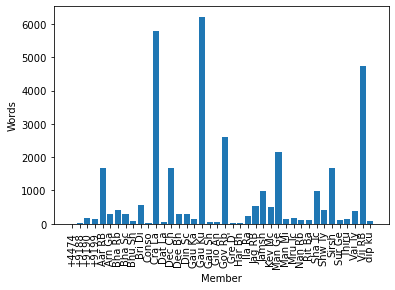

<Figure size 2160x720 with 0 Axes>

In [41]:
plt.bar(df_words.index, df_words['words'])
plt.xlabel('Member')
plt.ylabel('Words')
plt.xticks(rotation=90)
plt.figure(figsize=(30, 10))
plt.show()

In [42]:
df.columns

Index(['date', 'time_stamp', 'member', 'message', 'ShortNames', 'sickness',
       'words'],
      dtype='object')

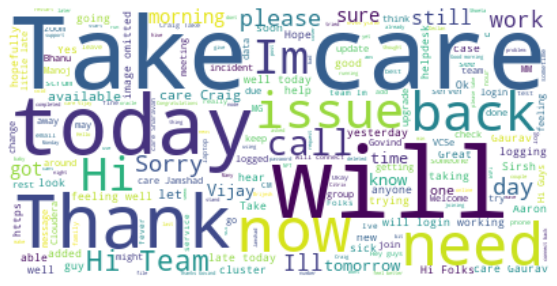

In [43]:
text = " ".join(review for review in df.message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [45]:
sia = SentimentIntensityAnalyzer()

In [46]:
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [47]:
# Adding sentiment score of each message posted
df['sentiments'] = df['message'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [48]:
df_sentiments = df[['ShortNames', 'sentiments']].groupby('ShortNames').mean()
df_sentiments['sentiments'] = df_sentiments['sentiments']*100
df_sentiments.head()

,sentiments
ShortNames,
+4474,0.000000
+9188,9.324000
+9190,11.787778
+9199,26.280909
Aar RB,13.216989


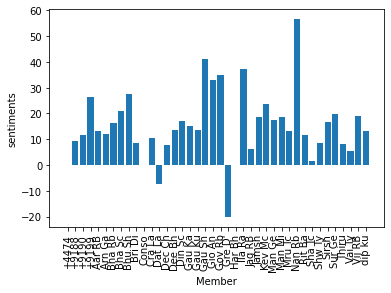

<Figure size 3600x720 with 0 Axes>

In [49]:
plt.bar(df_sentiments.index, df_sentiments['sentiments'])
plt.xlabel('Member')
plt.ylabel('sentiments')
plt.xticks(rotation=90)
plt.figure(figsize=(50, 10))
plt.show()

In [50]:
df_sentiments = df_sentiments.reset_index()

In [51]:
df_sentiments.columns = ['member', 'sentiments']

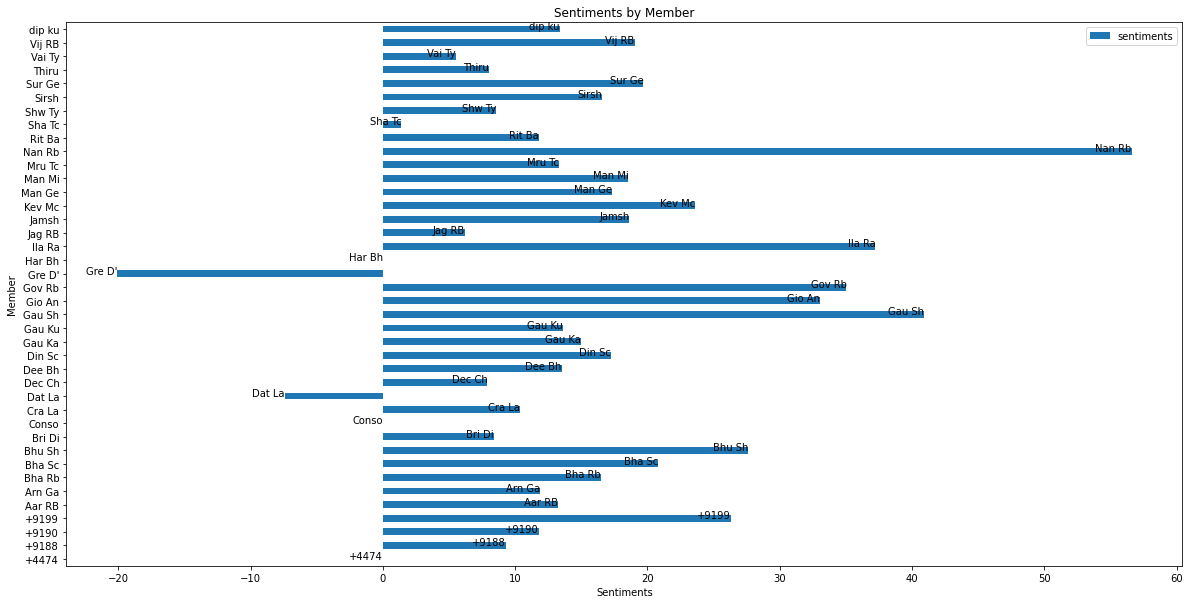

In [52]:
ax = df_sentiments.plot.barh(x='member', y='sentiments', figsize=(20, 10))
plt.xlabel('Sentiments')
plt.ylabel('Member')
plt.title('Sentiments by Member')

# Add member labels to each bar. 
for i, member in enumerate(df_sentiments['member']):
    ax.text(df_sentiments.loc[i, 'sentiments'], i, member, ha='right')
    # note that the text function takes(x,y,text) where both x and y need to be numerical    
plt.show()